In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import json
import matplotlib.pyplot as plt
% matplotlib inline

combined = pd.read_csv('all_hashtags_combined.csv')

In [2]:
# Collecting all the unique hashtags from tweets into a set
all_hashtags = set()

found_hashtags = combined.tweet_hashtags.unique()

for hts in found_hashtags:
    if type(hts) == str:
        parts = hts.split(' ')
        for part in parts:
            all_hashtags.add(part)

## Multigraph; first approach that was dropped

In [3]:
all_hashtags = list(all_hashtags)
tweets = len(combined)
all_edges = []

for i in range(tweets):
    tweet = combined.iloc[i]
    if type(tweet.tweet_hashtags) == str:
        mentions = tweet.text.split(' ') if type(tweet.text) == str else []
        hashtags = set() # set doesn't allow duplicates
        for ht in tweet.tweet_hashtags.split(' '):
            hashtags.add(ht)
        hashtags = list(hashtags) # Contains now only unique hashtags
    
        mentions_as_hts = [''.join(['#', x]) for x in mentions] # Turning mentions into hashtags
        mentions_as_hts = [x for x in mentions_as_hts if x not in hashtags] # Taking only the mentions that are NOT some existing hashtags IN THE SAME TWEET
    
        mentions_also_hashtags = [x for x in mentions_as_hts if x in all_hashtags] # Taking only the mentions that ARE existing hashtags (nodes) IN THE WHOLE NETWORK
    
        num_of_hts = len(hashtags)
        for j in range(num_of_hts):
            current_ht = hashtags[j]
        
            for mention_as_ht in mentions_also_hashtags: # Edge must be formed, when other node is a hashtag in the tweet and the other is a mention
                all_edges.append((current_ht, mention_as_ht))
            
            for k in range(j+1, num_of_hts): # Edge must be formed, when both nodes are hashtags in the tweet
                following_ht = hashtags[k]
                all_edges.append((current_ht, following_ht))

In [33]:
# Hashtags #a, #b, #c, #d
# All combinations, i.e. edges between them: #a#b , #a#c , #a#d , #b#c , #b#d , #c#d
# Mentions (turned into hashtags) #e, #f, #g (do not overlap with hashtags and are existing hashtags in the network)
# All additional combinations (edges): #a#e , #a#f , #a#g , #b#e , #b#f, #b#g , #c#e , #c#f , #c#g , #d#e , #d#f , #d#g

In [4]:
len(all_edges)

393448

In [5]:
len(all_hashtags)

13122

In [ ]:
G = nx.MultiGraph()
G.add_nodes_from(all_hashtags)
G.add_edges_from(all_edges)

In [ ]:
nx.write_gpickle(G, "hashtag_multigraph.gpickle")

In [22]:
draw_nodes = [x for x in all_hashtags if not (x == '#greenlight' or x == '#cruisemissiles')] # Leaving out the only two not connected nodes for visualization

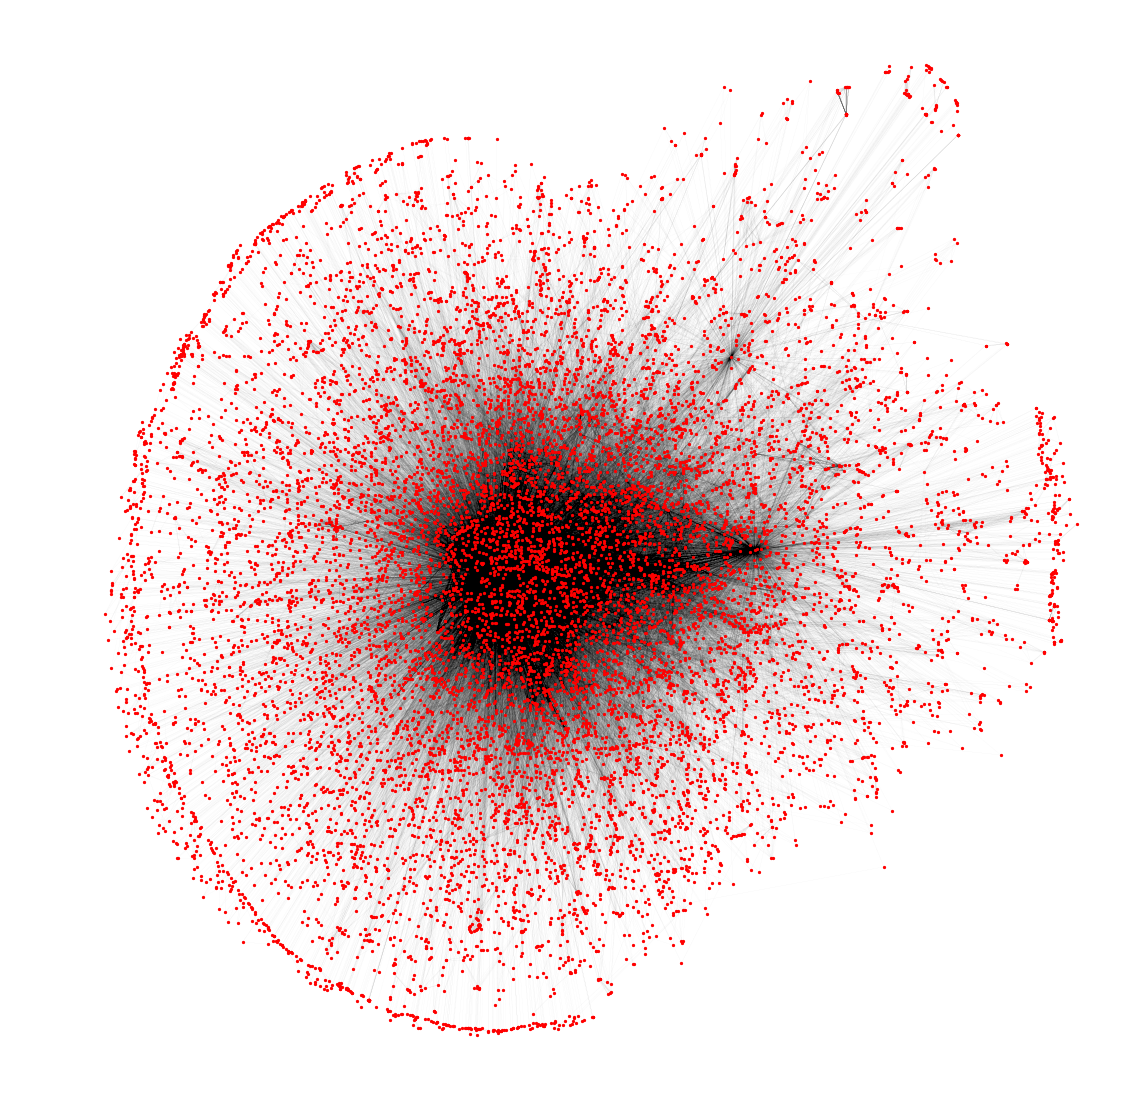

In [32]:
plt.rcParams['figure.figsize'] = (15, 15)
nx.draw(G, nodelist = draw_nodes, node_size = 5, width = 0.01, with_labels = False)
plt.savefig("hashtag_network.png")

### Summary table; Clustering coefficient not implemented for multigraph type

##### For the whole graph

In [69]:
n_of_nodes = nx.number_of_nodes(G)
n_of_edges = nx.number_of_edges(G)

In [70]:
giant = max(nx.connected_component_subgraphs(G), key=len)
giant_nodes = nx.number_of_nodes(giant)

In [60]:
#avg_path_length = nx.average_shortest_path_length(G)

In [72]:
d_centralities = nx.degree_centrality(G)
avg_degree_centrality = np.mean(list(d_centralities.values())) 

In [73]:
b_centralities = nx.betweenness_centrality(G)
avg_betweenness_centrality = np.mean(list(b_centralities.values())) 

In [61]:
#clustering_coeff = nx.average_clustering(G)

In [62]:
#diam = nx.diameter(G)

##### For the giant component

In [76]:
n_of_nodes_giant = nx.number_of_nodes(giant)
n_of_edges_giant = nx.number_of_edges(giant)

In [77]:
avg_path_length_giant = nx.average_shortest_path_length(giant)

In [78]:
d_centralities_giant = nx.degree_centrality(giant)
avg_degree_centrality_giant = np.mean(list(d_centralities_giant.values())) 

In [79]:
b_centralities_giant = nx.betweenness_centrality(giant)
avg_betweenness_centrality_giant = np.mean(list(b_centralities_giant.values())) 

In [63]:
#clustering_coeff_giant = nx.average_clustering(giant)

In [82]:
diam_giant = nx.diameter(giant)

In [80]:
with open('degree_centralities_multigraph.json', 'w') as file:
    json.dump(d_centralities, file)

with open('betweenness_centralities_multigraph.json', 'w') as file:
    json.dump(b_centralities, file)
    
with open('degree_centralities_multigraph_giant.json', 'w') as file:
    json.dump(d_centralities_giant, file)

with open('betweenness_centralities_multigraph_giant.json', 'w') as file:
    json.dump(b_centralities_giant, file)

In [86]:
pd.DataFrame({'Number of nodes': [n_of_nodes, n_of_nodes_giant], 
              'Number of edges': [n_of_edges, n_of_edges_giant], 
              'Size of giant component': [giant_nodes, n_of_nodes_giant], 
              'Average path length': [np.nan, avg_path_length_giant], 
              'Average degree centrality': [avg_degree_centrality, avg_degree_centrality_giant], 
              'Average in-betweeness centrality': [avg_betweenness_centrality, avg_betweenness_centrality_giant], 
              'Clustering Coefficient': [np.nan, np.nan],
              'Diameter': [np.nan, diam_giant]
             }, index = ['Multigraph', 'Giant Component']).to_csv('multigraph_summary.csv')

## Simple Undirected Graph; second approach, two different final graphs, hashtag network and park hashtag network

In [3]:
# Hashtags that contain word 'park' are only allowed to be nodes
park_hashtags = []
for h in all_hashtags:
    if 'park' in h:
         park_hashtags.append(h)

In [4]:
# Hashtags that occur at least in three tweets are allowed to be nodes
hashtags_count = {}

found_hashtags = combined.tweet_hashtags.unique()

for hts in found_hashtags:
    if type(hts) == str:
        parts = hts.split(' ')
        parts = np.array(parts) 
        parts = np.unique(parts)
        for part in parts:
            value = hashtags_count.get(part, None)
            if value == None:
                hashtags_count[part] = 1
            else:
                hashtags_count[part] = value + 1

node_hashtags = []
for htag, occurrence_count in hashtags_count.items():
    if occurrence_count > 2:
        node_hashtags.append(htag)

In [6]:
def form_edges(node_hashtags):
    '''
    Forms edges for the given hashtag nodes based on how hashtags occur in tweets; 
    Edge is formed only when both node hashtags are mentioned in a tweet, for example:
    Tweet hashtags #a, #b, #c, #d
    All combinations, i.e. all formed edges: #a#b , #a#c , #a#d , #b#c , #b#d , #c#d
    Returns a dictionary, where key is an edge and value is a list that contains two edge attributes:
    1. Total number of tweets that had edge's end nodes' hashtags in them
    2. A list of all the indexes of tweets that contributed to the formation of the edge in question; 
       will be helpful in community analysis as all the contributing tweets can be quickly found
        
    '''
    tweets = len(combined)
    edges = {}

    for i in range(tweets):
        tweet = combined.iloc[i]
        if type(tweet.tweet_hashtags) == str:
            hashtags = set() # set doesn't allow duplicates
            for ht in tweet.tweet_hashtags.split(' '):
                hashtags.add(ht)
            hashtags = list(hashtags) # Contains now only unique hashtags
        
            hashtags_also_nodes = [x for x in hashtags if x in node_hashtags] # Only hashtags that are also defined as nodes in the graph
            num_of_hts = len(hashtags_also_nodes)
            for j in range(num_of_hts):
                current_ht = hashtags_also_nodes[j]
            
                for k in range(j+1, num_of_hts): # Edge must be formed, when both nodes are hashtags in the tweet
                    following_ht = hashtags_also_nodes[k]

                    value = edges.get((current_ht, following_ht), None)
                    if value == None:
                        value2 = edges.get((following_ht, current_ht), None)
                        if value2 == None:
                            edges[(current_ht, following_ht)] = [1, [i]]
                        else:
                            edges[(following_ht, current_ht)][0] = value2[0] + 1
                            edges[(following_ht, current_ht)][1].append(i)
                    else:
                        edges[(current_ht, following_ht)][0] = value[0] + 1
                        edges[(current_ht, following_ht)][1].append(i)
    return edges

In [6]:
edges = form_edges(node_hashtags) # Edges for hashtag network
park_edges = form_edges(park_hashtags) # Edges for park hashtag network

In [7]:
len(park_hashtags)

664

In [8]:
len(park_edges)

1517

In [9]:
len(node_hashtags)

2217

In [10]:
len(edges)

28640

In [11]:
G2 = nx.Graph() # Park hashtag network
G2.add_nodes_from(park_hashtags)
for edge, value in park_edges.items():
    G2.add_edge(edge[0], edge[1])
    G2[edge[0]][edge[1]]['tweet_count'] = value[0]
    G2[edge[0]][edge[1]]['tweet_list'] = value[1]

In [12]:
G3 = nx.Graph() # Hashtag network
G3.add_nodes_from(node_hashtags)
for edge, value in edges.items():
    if value[0] > 2: # Edge is formed only when its end nodes are hashtags in at least three distinct tweets
        G3.add_edge(edge[0], edge[1])
        G3[edge[0]][edge[1]]['tweet_count'] = value[0]
        G3[edge[0]][edge[1]]['tweet_list'] = value[1]

# Removing nodes that have a degree of zero after forming edges
zero_degree_nodes = []
for node, deg in G3.degree():
    if deg == 0:
        zero_degree_nodes.append(node)
G3.remove_nodes_from(zero_degree_nodes)

In [13]:
nx.number_of_nodes(G3)

2073

In [14]:
nx.number_of_edges(G3)

6833

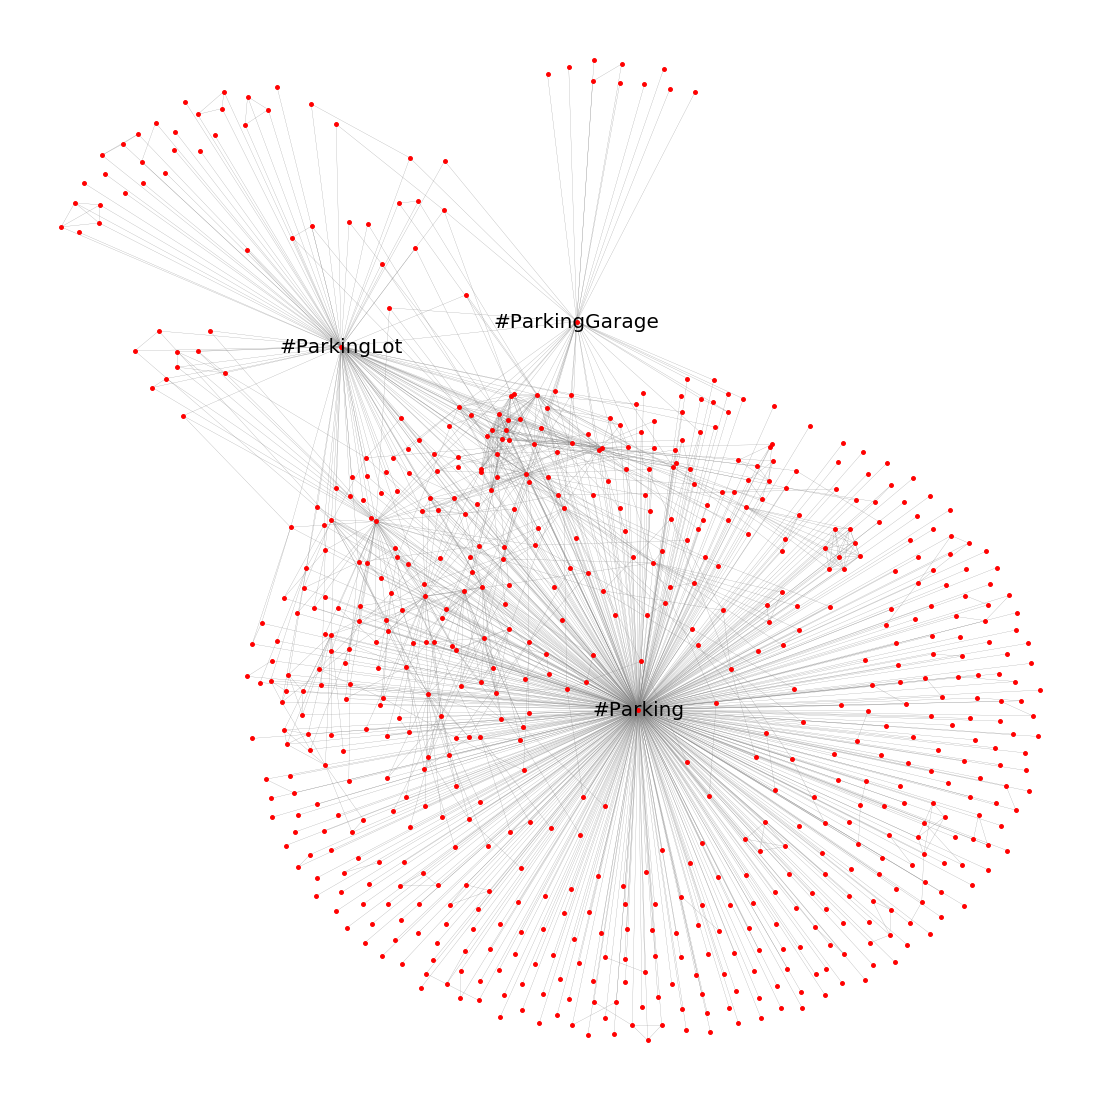

In [67]:
# Visualization of park hashtag network
plt.rcParams['figure.figsize'] = (15, 15)
pos = nx.spring_layout(G2)
nx.draw(G2, pos, node_color='red', node_size = 15, width = 0.2, edge_color= 'grey', with_labels = False)
nx.draw_networkx_labels(G2, pos, labels = {'#parking': '#Parking', '#parkinglot': '#ParkingLot', '#parkinggarage': '#ParkingGarage',}, 
                 font_size=20)
plt.savefig("park_hashtag_network.png")

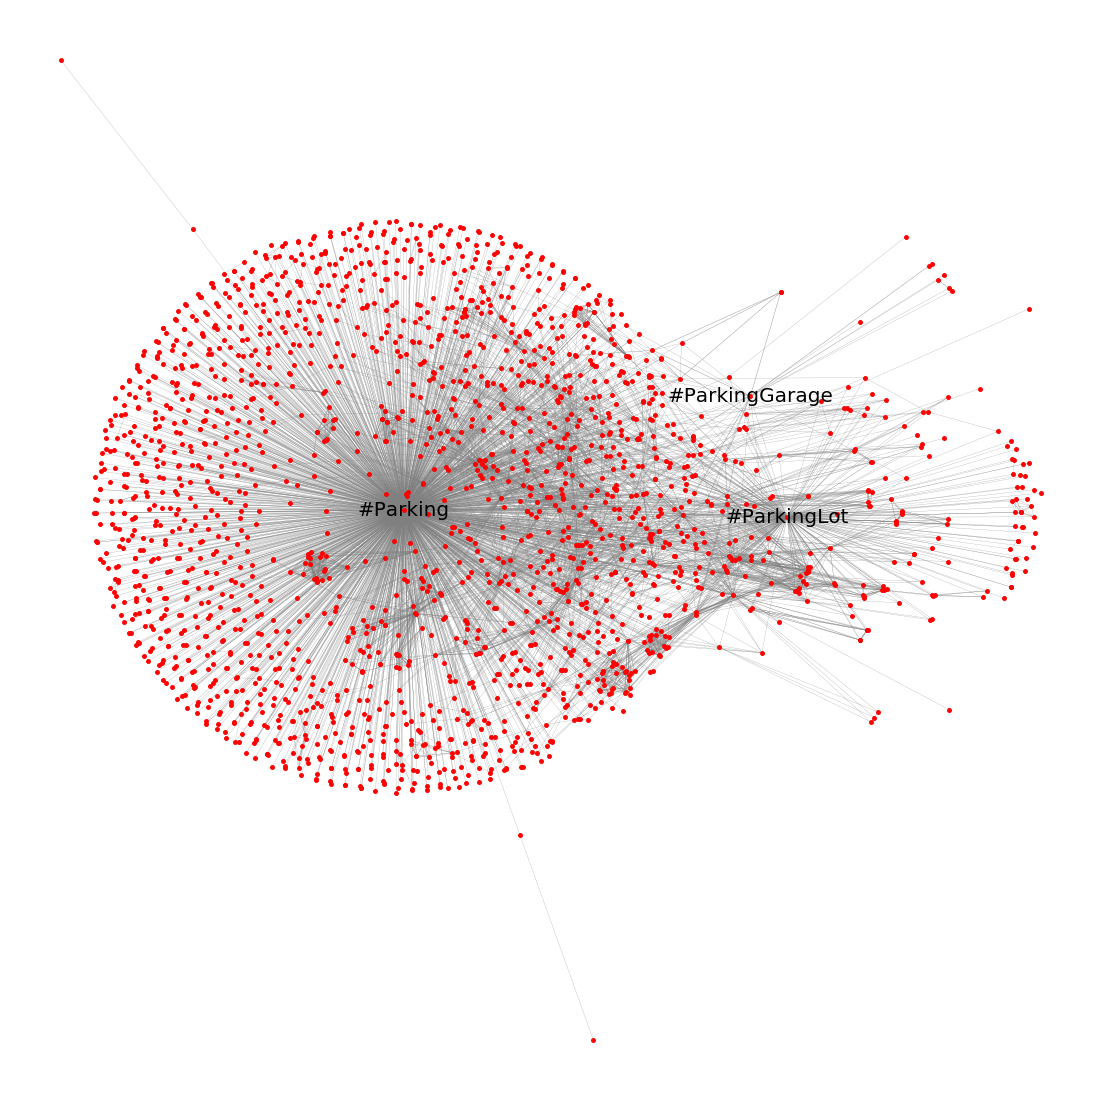

In [69]:
# Visualization of hashtag network
pos = nx.spring_layout(G3)
nx.draw(G3, pos, node_color='red', node_size = 15, width = 0.2, edge_color= 'grey',with_labels = False)
nx.draw_networkx_labels(G3, pos, labels = {'#parking': '#Parking', '#parkinglot': '#ParkingLot', '#parkinggarage': '#ParkingGarage',}, 
                 font_size=20)
plt.savefig("hashtag_network.png")

In [60]:
nx.write_gpickle(G2, "park_hashtag_network.gpickle")
nx.write_gpickle(G3, "hashtag_network.gpickle")

### Summary for the park hashtag network

##### For the whole graph, which is also the giant component

In [17]:
n_of_nodes_park = nx.number_of_nodes(G2)
n_of_edges_park = nx.number_of_edges(G2)

In [20]:
giant_park = G2.subgraph(sorted(nx.connected_components(G2), key=len, reverse=True)[0])
giant_nodes_park = nx.number_of_nodes(giant_park)

In [22]:
avg_path_length_park = nx.average_shortest_path_length(G2)

In [23]:
d_centralities_park = nx.degree_centrality(G2)
avg_degree_centrality_park = np.mean(list(d_centralities_park.values())) 

In [24]:
b_centralities_park = nx.betweenness_centrality(G2)
avg_betweenness_centrality_park = np.mean(list(b_centralities_park.values())) 

In [25]:
clustering_coeff_park = nx.average_clustering(G2)

In [26]:
diam_park = nx.diameter(G2)

In [34]:
pd.DataFrame({'Number of nodes': n_of_nodes_park, 
              'Number of edges': n_of_edges_park, 
              'Size of giant component': giant_nodes_park, 
              'Average path length': avg_path_length_park, 
              'Average degree centrality': avg_degree_centrality_park, 
              'Average in-betweeness centrality': avg_betweenness_centrality_park, 
              'Clustering Coefficient': clustering_coeff_park,
              'Diameter': diam_park
             }, index = ['Park hashtag network graph'])#.to_csv('park_hashtag_network_summary.csv')

,Number of nodes,Number of edges,Size of giant component,Average path length,Average degree centrality,Average in-betweeness centrality,Clustering Coefficient,Diameter
Park hashtag network graph,664,1517,664,2.14839,0.006892,0.001735,0.550231,3


In [28]:
with open('degree_centralities_park_hashtag_network.json', 'w') as file:
    json.dump(d_centralities_park, file)

with open('betweenness_centralities_park_hashtag_network.json', 'w') as file:
    json.dump(b_centralities_park, file)

In [29]:
from scipy import stats
degrees = [val for (node, val) in G2.degree()]
print(f"The maximum degree of the Graph is {np.max(degrees)}")   
print(f"The minimum degree of the Graph is {np.min(degrees)}")
print(f"The average degree of the nodes in the Graph is {np.mean(degrees):.1f}")  
print(f"The most frequent degree of the nodes found in the Graph is {stats.mode(degrees)[0][0]}")

The maximum degree of the Graph is 600
The minimum degree of the Graph is 1
The average degree of the nodes in the Graph is 4.6
The most frequent degree of the nodes found in the Graph is 1


In [53]:
max_degree_centrality = max(d_centralities_park.items(), key=(lambda k: k[1]))
print(f"the node with id {max_degree_centrality[0]} has a degree centrality of {max_degree_centrality[1]} which is the maximum of the Graph")
second_max_degree_centrality = sorted(d_centralities_park.items(), key=(lambda k: k[1]), reverse=True)[1]
print(f"the node with id {second_max_degree_centrality[0]} has a degree centrality of {second_max_degree_centrality[1]} which is the second largest of the Graph")

the node with id #parking has a degree centrality of 0.9049773755656109 which is the maximum of the Graph
the node with id #parkinglot has a degree centrality of 0.1779788838612368 which is the second largest of the Graph


In [54]:
max_betweeness_centrality= max(b_centralities_park.items(), key=(lambda k: k[1]))
print(f"the node with id {max_betweeness_centrality[0]} has a betweeness centrality of {max_betweeness_centrality[1]} which is the maximum of the Graph")
second_max_betweeness_centrality = sorted(b_centralities_park.items(), key=(lambda k: k[1]), reverse=True)[1]
print(f"the node with id {second_max_betweeness_centrality[0]} has a betweeness centrality of {second_max_betweeness_centrality[1]} which is the second largest of the Graph")

the node with id #parking has a betweeness centrality of 0.9342133691934107 which is the maximum of the Graph
the node with id #parkinglot has a betweeness centrality of 0.12459099298171969 which is the second largest of the Graph


### Summary for the hashtag network

##### For the whole graph, which is also the giant component

In [35]:
n_of_nodes = nx.number_of_nodes(G3)
n_of_edges = nx.number_of_edges(G3)

In [36]:
giant = G3.subgraph(sorted(nx.connected_components(G3), key=len, reverse=True)[0])
giant_nodes = nx.number_of_nodes(giant)

In [37]:
avg_path_length = nx.average_shortest_path_length(G3)

In [38]:
d_centralities = nx.degree_centrality(G3)
avg_degree_centrality = np.mean(list(d_centralities.values())) 

In [39]:
b_centralities = nx.betweenness_centrality(G3)
avg_betweenness_centrality = np.mean(list(b_centralities.values())) 

In [40]:
clustering_coeff = nx.average_clustering(G3)

In [41]:
diam = nx.diameter(G3)

In [45]:
pd.DataFrame({'Number of nodes': n_of_nodes, 
              'Number of edges': n_of_edges, 
              'Size of giant component': giant_nodes, 
              'Average path length': avg_path_length, 
              'Average degree centrality': avg_degree_centrality, 
              'Average in-betweeness centrality': avg_betweenness_centrality, 
              'Clustering Coefficient': clustering_coeff,
              'Diameter': diam
             }, index = ['Hashtag network'])#.to_csv('hashtag_network_summary.csv')

,Number of nodes,Number of edges,Size of giant component,Average path length,Average degree centrality,Average in-betweeness centrality,Clustering Coefficient,Diameter
Hashtag network,2073,6833,2073,2.129676,0.003182,0.000545,0.510514,5


In [46]:
with open('degree_centralities_hashtag_network.json', 'w') as file:
    json.dump(d_centralities, file)

with open('betweenness_centralities_hashtag_network.json', 'w') as file:
    json.dump(b_centralities, file)

In [47]:
degrees = [val for (node, val) in G3.degree()]
print(f"The maximum degree of the Graph is {np.max(degrees)}")   
print(f"The minimum degree of the Graph is {np.min(degrees)}")
print(f"The average degree of the nodes in the Graph is {np.mean(degrees):.1f}")  
print(f"The most frequent degree of the nodes found in the Graph is {stats.mode(degrees)[0][0]}")

The maximum degree of the Graph is 1913
The minimum degree of the Graph is 1
The average degree of the nodes in the Graph is 6.6
The most frequent degree of the nodes found in the Graph is 1


In [51]:
max_degree_centrality = max(d_centralities.items(), key=(lambda k: k[1]))
print(f"the node with id {max_degree_centrality[0]} has a degree centrality of {max_degree_centrality[1]} which is the maximum of the Graph")
second_max_degree_centrality = sorted(d_centralities.items(), key=(lambda k: k[1]), reverse=True)[1]
print(f"the node with id {second_max_degree_centrality[0]} has a degree centrality of {second_max_degree_centrality[1]} which is the second largest of the Graph")

the node with id #parking has a degree centrality of 0.9232625482625483 which is the maximum of the Graph
the node with id #parkinglot has a degree centrality of 0.14623552123552125 which is the second largest of the Graph


In [52]:
max_betweeness_centrality = max(b_centralities.items(), key=(lambda k: k[1]))
print(f"the node with id {max_betweeness_centrality[0]} has a betweeness centrality of {max_betweeness_centrality[1]} which is the maximum of the Graph")
second_max_betweeness_centrality = sorted(b_centralities.items(), key=(lambda k: k[1]), reverse=True)[1]
print(f"the node with id {second_max_betweeness_centrality[0]} has a betweeness centrality of {second_max_betweeness_centrality[1]} which is the second largest of the Graph")

the node with id #parking has a betweeness centrality of 0.9566187200546932 which is the maximum of the Graph
the node with id #parkinglot has a betweeness centrality of 0.08056298313600696 which is the second largest of the Graph
